# Introduction to Computational science - Assignment 2
Sander Broos, Nick van Santen

In [1]:
# Imports
from __future__ import annotations
from ipywidgets import *

import math
import matplotlib.pyplot as plt
import numpy as np

from typing import Callable, List

In [2]:
# Run cell to increase font sizes. Usefull when saving plots
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
class Event:

    def __init__(self, name: str, rate: Callable, event: dict):

        self.name = name
        self.event = event

        self.rate = rate

    def occur(self, groups, time):
        
        for group, value_to_add in self.event.items():
            groups[group].add_value(value_to_add, time)

class Simulator:

    def __init__(self, groups: List[Group], events: List[Event], max_time: float):

        self.groups = groups

        self.events = events

        self.time = 0
        self.max_time = max_time
        self.time_steps = [0]
    
    def update(self):

        total_rate = sum([event.rate(self.groups) for event in self.events])

        if total_rate == 0:
            self.time = self.max_time
            return

        r1 = np.random.rand()
        delta_time = -1 / total_rate * np.log(r1)
        self.time += delta_time

        if self.time > self.max_time:
            return

        self.time_steps.append(self.time)
        
        r2 = np.random.rand()
        P = r2 * total_rate
        event = self.determine_event(P)

        # Apply event
        event.occur(self.groups, self.time)

    def determine_event(self, p: float):
        
        value = 0
        for event in self.events:

            value += event.rate(self.groups)

            if value > p:
                return event
        
        print("ERROR: No event found")
        return None
    
    def total_n(self):
        return sum([group.number for group in self.groups.values()])
    
    def run(self):

        while self.time < self.max_time:
            self.update()

        self.finalise_results()

    def reset(self):
        
        for group in self.groups.values():
            group.reset()

        self.time = 0
        self.time_steps = [0]
         
    def finalise_results(self):

        for group in self.groups.values():

            group.append_to_history(group.number, self.max_time)

    def plot_group_levels(self):

        for group in self.groups.values():

            plt.plot(group.time_steps, group.history, label=group.name, drawstyle="steps-post")

        plt.legend()
        plt.show()

    def print_group_levels(self):

        for group in self.groups.values():

            print(f"{group.name}: {group.number}")

class Group:

    def __init__(self, name: str, initial: int):
        
        self.initial = initial
        self.name = name
        self.history = [initial]
        self.time_steps = [0]

    @property
    def number(self):
        return self.history[-1]

    def add_value(self, value: int, time: float):

        self.append_to_history(self.number + value, time)

    def append_to_history(self, value: int, time: float):
        
        self.history.append(value)
        self.time_steps.append(time)

    def reset(self):
        
        self.__init__(self.name, self.initial)
    
    def __str__(self):

        return f"{self.name}: {self.history}"


In [4]:
class SIRSimulator(Simulator):

    def __init__(self, beta=3.0, gamma=1.0, delta=0.0, epsilon=0.0, mu=0.0, s_init=1000, i_init=5, r_init=0, max_time=10.0, **kwargs):

        groups = {
            "susceptible": Group("susceptible", s_init),
            "infected": Group("infected", i_init),
            "recovered": Group("recovered", r_init),
        }
        
        events = [
            Event(name="birth", 
                rate=lambda groups: mu * self.total_n(), 
                event={"susceptible": 1}),
            Event(name="transmission", 
                rate=lambda groups: beta * groups["susceptible"].number * groups["infected"].number / self.total_n(), 
                event={"susceptible": -1, "infected": 1}),
            Event(name="recovery", 
                rate=lambda groups: gamma * groups["infected"].number, 
                event={"infected": -1, "recovered": 1}),
            Event(name="death_s", 
                rate=lambda groups: mu * groups["susceptible"].number, 
                event={"susceptible": -1}),
            Event(name="death_i", 
                rate=lambda groups: mu * groups["infected"].number, 
                event={"infected": -1}),
            Event(name="death_r", 
                rate=lambda groups: mu * groups["recovered"].number, 
                event={"recovered": -1}),
            Event(name="import_move_in", 
                rate=lambda groups: delta * self.total_n()**0.5, 
                event={"infected": 1}),
            Event(name="import_pass_through", 
                rate=lambda groups: epsilon * groups["susceptible"].number * ((beta / (gamma + mu)) - 1) / self.total_n()**0.5, 
                event={"susceptible": -1, "infected": 1}),
        ]

        super().__init__(groups, events, max_time)
    

In [5]:

def sir_gillespie(beta=3.0, gamma=1.0, delta=0.0, epsilon=0.0, mu=0.0, s_init=1000, i_init=5, r_init=0, max_time=10.0, show_plot=True):

    sim = SIRSimulator(**locals())
    sim.run()
    
    if show_plot:
        plt.clf()
        sim.plot_group_levels()

    return sim


In [6]:
%matplotlib widget

interactive(sir_gillespie, beta=(0, 5.0), gamma=(0, 5.0), delta=(0, 5.0), epsilon=(0, 5.0, 0.01), mu=(0, 1.0, 0.01), s_init=(0, 2000), i_init=(0, 1000), r_init=(0, 1000), max_time=(0, 1000), show_plot=True)

interactive(children=(FloatSlider(value=3.0, description='beta', max=5.0), FloatSlider(value=1.0, description=…

In [ ]:
N_values = range(100000, 1000000, 100000)
avg_values = []

for N in N_values:

    print(N)
    all_extinctions = []

    for _ in range(10):

      sim = sir_gillespie(beta=1.0, gamma=0.1, mu=5.5*10**-5, delta=0.02/365, s_init=N, i_init=0, max_time=365, show_plot=False)

      extinctions = 0
      infected_history = sim.groups["infected"].history

      for i in range(1, len(infected_history)):

        if infected_history[i] == 0 and infected_history[i-1] != 0:
            extinctions += 1
      
      all_extinctions.append(extinctions/10.0)
    
    avg_values.append(np.mean(all_extinctions))

plt.plot(N_values, avg_values)
plt.show()

## Extinction

Calculating critical size for beta=0.5 and gamma=0.6 N: 12700, dN 6400ERROR: No critical size was found

Calculating critical size for beta=0.6 and gamma=0.6 N: 12700, dN 6400ERROR: No critical size was found

Calculating critical size for beta=0.7 and gamma=0.6 N: 12700, dN 6400ERROR: No critical size was found

Calculating critical size for beta=0.8 and gamma=0.6 N: 12700, dN 6400ERROR: No critical size was found

Calculating critical size for beta=0.9 and gamma=0.6 N: 5292.1875, dN 1.5625
Calculating critical size for beta=1.0 and gamma=0.6 N: 1107.8125, dN 1.5625
Calculating critical size for beta=1.1 and gamma=0.6 N: 489.0625, dN 1.5625
Calculating critical size for beta=1.2 and gamma=0.6 N: 282.8125, dN 1.5625
Calculating critical size for beta=1.3 and gamma=0.6 N: 135.9375, dN 1.5625
Calculating critical size for beta=1.5 and gamma=0.6 N: 98.4375, dN 1.5625
Calculating critical size for beta=1.7 and gamma=0.6 N: 92.1875, dN 1.5625
Calculating critical size for beta=2.0 and gamma

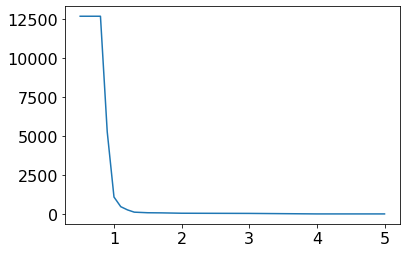

[12700, 12700, 12700, 12700, 5292.96875, 1107.03125, 488.28125, 282.03125, 136.71875, 99.21875, 91.40625, 67.96875, 57.03125, 24.21875, 24.21875]
[0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.5, 1.7, 2, 3, 4, 5]


In [9]:
%matplotlib inline

def calc_critical_size(beta, gamma, max_time=100, treshold=0.8, precision=1, nruns=10, size_guess=100):
    """
    Calculates the critical size of a system. At the critical size the system goes extinct
    <treshold> percent of the time. It uses some version of binary search to find the critical
    size. At first it calculates if the initial size results in extinction, then it decreases 
    or increases the size exponentially until the opposite result of the initial system is found.
    (the crossover) Now we know at which region the critical size should be. We then start reducing 
    our step sizes until we are at our critical size.
    """

    infection_percentage = 0.1

    # Naive approach
    # for N in np.logspace(1, 4, 20):
    #     s_init = int((1 - infection_percentage) * N)
    #     i_init = int(N - s_init)
        
    #     sim = SIRSimulator(beta=beta, gamma=gamma, mu=0.3, s_init=s_init, i_init=i_init, max_time=max_time)

    #     print(f"{N}: {is_extinct_rate_above_treshold(sim, treshold)}")
    #     # sim.plot_group_levels()

    # return


    N = size_guess
    dN = N
    
    # Get the result of the initial system
    s_init = int((1 - infection_percentage) * N)
    i_init = int(N - s_init)
    sim = SIRSimulator(beta=beta, gamma=gamma, mu=0.3, s_init=s_init, i_init=i_init, max_time=max_time)
    initial_extinct = is_extinct_rate_above_treshold(sim, treshold)

    crossover_found = False

    while dN > precision:
        
        print(f"\rCalculating critical size for beta={beta:.1f} and gamma={gamma:.1f} N: {N}, dN {dN} ", end="")

        # Upper- and lower bounds of the sizes we're chechking. This is done since the results either dont
        # make sence or because the runs would take too long
        if N > 10000 or N < 10:
            
            print("ERROR: Critical size is out of range")
            break

        s_init = int((1 - infection_percentage) * N)
        i_init = int(N - s_init)     
        sim = SIRSimulator(beta=beta, gamma=gamma, mu=0.3, s_init=s_init, i_init=i_init, max_time=max_time)
        extinct = is_extinct_rate_above_treshold(sim, treshold, nruns=nruns)
        
        if not crossover_found:

            crossover_found = initial_extinct != extinct

        # Update the step size
        if crossover_found or not crossover_found and not extinct:
            dN /= 2
        else:
            dN *= 2

        # Update the size
        if extinct:
            N += dN

        if not extinct:
            N -= dN
    
    print()

    return N

def goes_extinct(sim):
    """
    Checks if a single run of a SIR simulator results in a extinction.
    Returns True if an extinction is reached, else False.
    """

    while sim.time < sim.max_time:
        sim.update()

        if sim.groups["infected"].number == 0.0:
            sim.finalise_results()
            return True
    
    return False

def is_extinct_rate_above_treshold(sim, treshold, nruns=10):
    """
    Checks if a simulator results in a extinction for more than <treshold> percent of the time.

    <treshold> has a range of 0 to 1
    """


    # Calculate the number of extinctions or non extinctions needed to reach the treshold
    # This is used to pre-emptively obtain the results. For example if we have 100 runs
    # and a treshold of 50% and the first 51 runs result in an extinction, then we dont
    # need to run the other 49 runs, since we will always be above the treshold.
    n_extinctions_treshold = math.ceil(nruns * treshold)
    n_non_extinctions_treshold = nruns - n_extinctions_treshold
    
    n_extinctions = 0
    n_non_extinctions = 0

    for _ in range(nruns):
        
        sim.reset()

        extinct = goes_extinct(sim)

        # TODO could be one line
        if extinct:
            n_extinctions += 1
        else:
            n_non_extinctions += 1

        if n_extinctions > n_extinctions_treshold:
            return True

        if n_non_extinctions > n_non_extinctions_treshold:
            return False

    return True

sizes = []
betas = [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.5, 1.7, 2, 3, 4, 5]


for beta in betas:
    size = calc_critical_size(beta, 0.6, max_time=100, nruns=10, precision=5)
    sizes.append(size)
    
plt.plot(betas, sizes)
plt.show()

print(sizes)
print(betas)
    

Some results for the critical size

N: 241.25, dN 1.25
N: 263.75, dN 1.25
N: 228.75, dN 1.25
N: 241.25, dN 1.25
N: 271.25, dN 1.25
N: 331.25, dN 1.25
N: 316.25, dN 1.25
N: 188.75, dN 1.25
N: 243.75, dN 1.25
N: 241.25, dN 1.25
approx 4 minutes, 10 runs, avg ~256.8

N: 223.75, dN 1.25
N: 193.75, dN 1.25
N: 238.75, dN 1.25
N: 221.25, dN 1.25
N: 266.25, dN 1.25
N: 271.25, dN 1.25
N: 253.75, dN 1.25
N: 271.25, dN 1.25
N: 311.25, dN 1.25
N: 241.25, dN 1.25
approx 6 minutes, 20 runs, avg ~249.3

N: 233.75, dN 1.25
N: 238.75, dN 1.25
N: 218.75, dN 1.25
N: 228.75, dN 1.25
N: 236.25, dN 1.25
N: 228.75, dN 1.25
N: 251.25, dN 1.25
N: 233.75, dN 1.25
N: 236.25, dN 1.25
N: 233.75, dN 1.25
approx 35 minutes, 100 runs, avg ~233.9 

[2550, 2550, 2550, 2550, 2550, 706.875, 359.375, 218.125, 190.625, 108.125, 86.875, 68.125, 46.875, 36.875, 35.625]
[0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.5, 1.7, 2, 3, 4, 5]

